In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime, pytz

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Hyperparameter

In [2]:
SEQ_LEN = 6 # 6, 11, 21
SPLIT = 0.80 # 0.80, 0.90
LSTM_Layer = 1 # 1, 2, 3
WINDOW_SIZE = SEQ_LEN - 1

In [3]:
# Google Spreadsheet ID
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = ['USD/IDR', 'EUR/IDR', 'SGD/IDR']

url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME[2]}'
data = pd.read_csv(url)

# Convert Date columns to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1959 entries, 0 to 1958
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1959 non-null   datetime64[ns]
 1   Close   1959 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 30.7 KB


## Preprocessing

In [4]:
scaler = MinMaxScaler()
close_price = data.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1959, 1)

In [5]:
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = SPLIT)

## Genetic Algorithm

In [6]:
# Genetic Algorithm
def genetic_algorithm(population_size, generations):
    population = np.random.randint(1, high=26, size=(population_size, 3))
    
    for generation in range(generations):
        print(f"Generation - {generation + 1}")
        fitness_scores = np.array([fitness_function(chromosome) for chromosome in population])
        best_chromosome = population[np.argmax(fitness_scores)]
        best_fitness = np.max(fitness_scores)
        
        new_population = []
        
        while len(new_population) < population_size:
            parent1 = selection(population, fitness_scores)
            parent2 = selection(population, fitness_scores)
            offspring_1, offspring_2 = crossover(parent1, parent2)
            mutate(offspring_1)
            mutate(offspring_2)
            new_population.append(offspring_1)
            new_population.append(offspring_2)
        
        population = np.array(new_population)
    
    return best_chromosome, best_fitness

# Selection (Tournament selection)
def selection(population, fitness_scores, tournament_size=3):
    indices = np.random.randint(len(population), size=tournament_size)
    tournament = population[indices]
    tournament_fitness = fitness_scores[indices]
    return tournament[np.argmax(tournament_fitness)]

# Crossover (Single-point crossover)
def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, len(parent1))
    offspring_1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    offspring_2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return offspring_1, offspring_2

# Mutation (Swap Mutation)
def mutate(chromosome, mutation_rate=0.01):
    for i in range(len(chromosome)):
        if np.random.rand() < mutation_rate:
            j = np.random.randint(len(chromosome))
            chromosome[i], chromosome[j] = chromosome[j], chromosome[i]

# Define the fitness function to be optimized
def fitness_function(chromosome):
    lstm_units = [int(chromosome[i]*10) or default for i, default in enumerate([128, 64, 32])]

    # Build the LSTM model
    tf.keras.backend.clear_session()
    model = Sequential()
    for i, units in enumerate(lstm_units[:LSTM_Layer]):
        model.add(LSTM(units, return_sequences=(i < LSTM_Layer - 1), input_shape=(WINDOW_SIZE, 1)))
    model.add(Dense(1))
    
    # Compile and train the model
    model.compile(loss='mean_squared_error',
                  optimizer='adam')
    model.fit(X_train, y_train,
              epochs=10,
              batch_size=32,
              verbose=0,
              validation_split=0.1)

    # Evaluate the model
    loss = model.evaluate(X_test, y_test)

    # Return the negative value of the loss as the fitness score
    return -loss

In [7]:
import typing
from datetime import datetime

def timer(start_time: datetime = None) -> "typing.Union[datetime.datetime, str]":
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        return "%i hours %i minutes and %s seconds." % (
            thour,
            tmin,
            round(tsec, 2),
        )

In [8]:
# Do not increase this value
population_size = 5
generations = 25

time = timer(None)
best_chromosome, best_fitness = genetic_algorithm(population_size, generations)
time = timer(time)

Generation - 1
13/13 [==============================] - 0s 3ms/step - loss: 6.8107e-04
Generation - 2
13/13 [==============================] - 0s 3ms/step - loss: 0.0014
Generation - 3
13/13 [==============================] - 0s 2ms/step - loss: 5.4401e-04
Generation - 4
13/13 [==============================] - 0s 3ms/step - loss: 5.9361e-04
Generation - 5
13/13 [==============================] - 0s 2ms/step - loss: 0.0029
Generation - 6
13/13 [==============================] - 0s 2ms/step - loss: 6.3072e-04
Generation - 7
13/13 [==============================] - 0s 2ms/step - loss: 6.0159e-04
Generation - 8
13/13 [==============================] - 0s 2ms/step - loss: 0.0011
Generation - 9
13/13 [==============================] - 0s 3ms/step - loss: 9.4057e-04
Generation - 10
13/13 [==============================] - 0s 2ms/step - loss: 0.0011
Generation - 11
13/13 [==============================] - 0s 2ms/step - loss: 0.0017
Generation - 12
13/13 [==============================] - 0s 2

In [9]:
print("Best Chromosome:", best_chromosome)
print("Best Fitness:", best_fitness)
print("Time Taken:", time)

Best Chromosome: [25 20 20]
Best Fitness: -0.0005484818248078227
Time Taken: 0 hours 14 minutes and 45.29 seconds.


## Re-Training Model with Best Parameter

In [10]:
model = Sequential()
for i, units in enumerate(best_chromosome[:LSTM_Layer]):
    model.add(LSTM(units*10, return_sequences=(i < LSTM_Layer - 1), input_shape=(WINDOW_SIZE, 1)))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 250)               252000    
                                                                 
 dense_1 (Dense)             (None, 1)                 251       
                                                                 
Total params: 252,251
Trainable params: 252,251
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='mean_squared_error',
              metrics=['mae', RootMeanSquaredError()],
              optimizer='adam')

history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/50
44/44 [==============================] - 3s 17ms/step - loss: 0.0136 - mae: 0.0771 - root_mean_squared_error: 0.1165 - val_loss: 4.5616e-04 - val_mae: 0.0172 - val_root_mean_squared_error: 0.0214
Epoch 2/50
44/44 [==============================] - 0s 5ms/step - loss: 0.0028 - mae: 0.0303 - root_mean_squared_error: 0.0529 - val_loss: 3.8997e-04 - val_mae: 0.0158 - val_root_mean_squared_error: 0.0197
Epoch 3/50
44/44 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0296 - root_mean_squared_error: 0.0524 - val_loss: 3.3815e-04 - val_mae: 0.0146 - val_root_mean_squared_error: 0.0184
Epoch 4/50
44/44 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0281 - root_mean_squared_error: 0.0515 - val_loss: 3.7644e-04 - val_mae: 0.0154 - val_root_mean_squared_error: 0.0194
Epoch 5/50
44/44 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0296 - root_mean_squared_error: 0.0519 - val_loss: 4.0715e-04 - val_mae: 0.0162 - val_r

In [12]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 3ms/step - loss: 0.0011 - mae: 0.0264 - root_mean_squared_error: 0.0325


[0.0010587807046249509, 0.026421766728162766, 0.03253890946507454]

## Model Evaluation

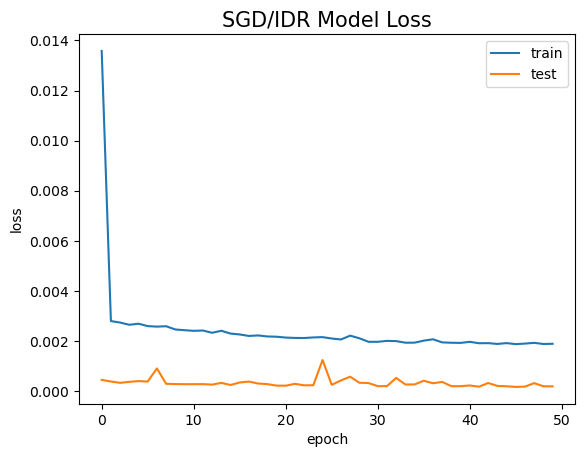

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'{SHEET_NAME[2]} Model Loss', fontsize=15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [14]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

13/13 [==============================] - 0s 2ms/step


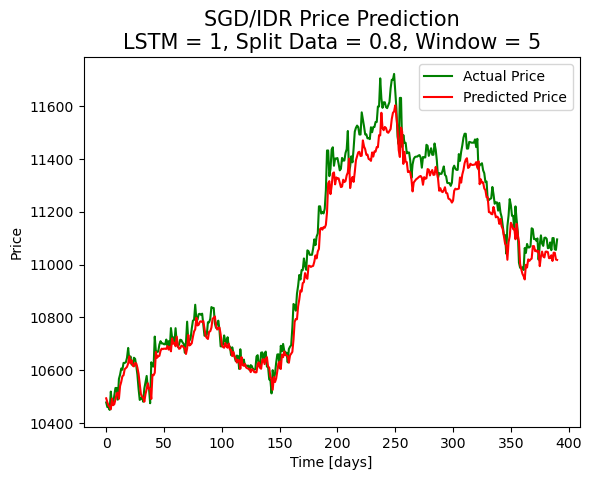

In [15]:
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title(f'{SHEET_NAME[2]} Price Prediction\nLSTM = {LSTM_Layer}, Split Data = {SPLIT}, Window = {WINDOW_SIZE}', fontsize=15)
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

In [16]:
def matrices(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    print("Mean Absolute Error for prediction :", mae)
    print("Mean Squared Error for prediction :", mse)
    print("Root Mean Squared Error for prediction :", rmse)
    return mae, mse, rmse

print(f"LSTM = {LSTM_Layer}, Split Data = {SPLIT}, Window = {WINDOW_SIZE}")
print("\n----------------- Normalized Error -----------------")
mae, mse, rmse = matrices(y_test, y_hat)
print("\n----------------- Actual Error -----------------")
mae_inverse, mse_inverse, rmse_inverse = matrices(y_test_inverse, y_hat_inverse)

LSTM = 1, Split Data = 0.8, Window = 5

----------------- Normalized Error -----------------
Mean Absolute Error for prediction : 0.026421768294582794
Mean Squared Error for prediction : 0.001058780810567527
Root Mean Squared Error for prediction : 0.03253891225237142

----------------- Actual Error -----------------
Mean Absolute Error for prediction : 55.709130834398934
Mean Squared Error for prediction : 4706.90104825267
Root Mean Squared Error for prediction : 68.60685860941798
